## 2 Condensation-Algorithm for Tracking (10 points)
---
Group 3:
* Jiye Lee
* Eduardo Venegas Hernández
---
The goal of this task is to track a rectangle over time using the Condensation-Algorithm
(also known as particle filter) and SIR (sequential importance resampling). This algorithm
tracks the rectangle in the face of several problems that arise from the image data:
- the motion direction changes
- the rectangle accelerates or slows down
- the rectangle is not always completely visible
- the rectangle moves out of the image and re-enters it at a different location
- the signal is corrupted by strong noise

┌ Info: Saved animation to /home/lalo/Uni/CV/Assignment 5/moving_dots.gif
└ @ Plots /home/lalo/.julia/packages/Plots/qgrW8/src/animation.jl:149


Plots.AnimatedGif("/home/lalo/Uni/CV/Assignment 5/moving_dots.gif")
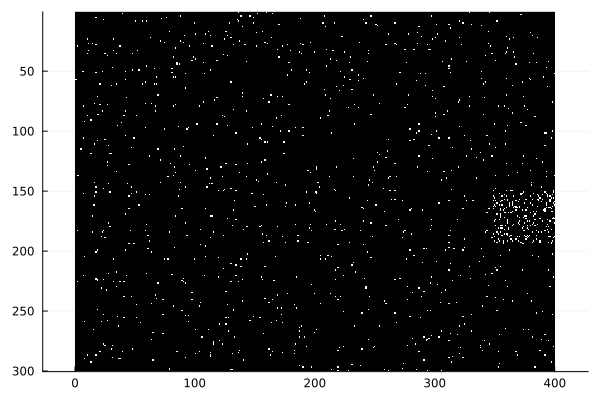

In [1]:
using Printf, Images, Plots
include("measure_probability.jl")

function readImages(img_dir, num1, num2)
    img = []
    for i in num1:num2
      current_img = load(Printf.format(Printf.Format(img_dir), i))
      push!(img, Gray.(current_img))
    end
    return img
end

images = readImages("moving_dots/moving_dots_%03i.png", 1, 100);

anim = @animate for img in images
  heatmap(img, color=:grays)
end

gif(anim, "moving_dots.gif", fps = 15)

The algorithm tracks the object with the help of a defined number of particles, which are
initially distributed evenly over the search area and later accumulate around the rectangle.
Each particle comprises 6 parameters. Four of these serve to estimate the properties of the
object: position (x, y) and velocity $(v_x, v_y)$. The other two parameters are particle weight w
and cumulative weight c

Implement the full algorithm by executing the following steps for t=1:100: 
- Initialize (only once): uniform distribution of all N = 1000 particles over the image;
normally distributed initial velocities with $σ_{vx,vy} = 1.0$; particle weight $w_n = \frac{1}{N}$ ;
cumulative weight $c_n = n · \frac{1}{N}$

In [3]:
# Implement the full algorithm by executing the following steps for t=1:100: 
#   - Initialize (only once): uniform distribution of all N = 1000 particles over the image;
#   normally distributed initial velocities with $σ_{vx,vy} = 1.0$; particle weight $w_n = \frac{1}{N}$ ;
#   cumulative weight $c_n = n · \frac{1}{N}$

struct Particle
    x::Float64
    y::Float64
    vx::Float64
    vy::Float64
    w::Float64
    c::Float64
end

function init_particles(N=1000)
    particles = []
    sizey, sizex = size(images[:][1])
    for i in 1:N
        x = rand(1:sizex)
        y = rand(1:sizey)
        vx = randn()
        vy = randn()
        w = 1/N
        c = i/N
        push!(particles, Particle(x, y, vx, vy, w, c))
    end
    return particles
end

init_particles (generic function with 2 methods)

- Load the current image and convert it to a grayscale, floating point matrix.

In [4]:
# - Load the current image and convert it to a grayscale, floating point matrix.

function load_image(img)
    img = convert(Array{Float64}, img)
    return img
end

load_image (generic function with 1 method)

In [5]:
# - Resampling step: generate a new set of N particles. Each particle should be initialized
# by drawing a random number r ∈ [0, 1] uniformly and identifying the particle i with
# the smallest cumulative weight $c_i ≥ r$ (from the set of old particles). The new particle
# has the same parameters as i. 

function resample(particles)
    N = length(particles)
    new_particles = []
    for i in 1:N
        r = rand()
        for j in 1:N
            if particles[j].c >= r
                push!(new_particles, particles[j])
                break
            end
        end
    end
    return new_particles
end

resample (generic function with 1 method)

- Prediction step (drift + diffusion): the new particle positions are calculated according
to their velocity (drift), followed by diffusion of the position with $σ_{x,y} = 0.5$ and diffusion
of velocity with $σ_{vx,vy} = 1.0$. 

In [6]:
# - Prediction step (drift + diffusion): the new particle positions are calculated according
# to their velocity (drift), followed by diffusion of the position with $σ_{x,y} = 0.5$ and diffusion
# of velocity with $σ_{vx,vy} = 1.0$. 

function predict(particles)
    N = length(particles)
    new_particles = []
    for i in 1:N
        x = particles[i].x + particles[i].vx + randn() * 0.5
        y = particles[i].y + particles[i].vy + randn() * 0.5
        vx = particles[i].vx + randn()
        vy = particles[i].vy + randn()
        w = particles[i].w
        c = particles[i].c
        push!(new_particles, Particle(x, y, vx, vy, w, c))
    end
    return new_particles
end

predict (generic function with 1 method)

- Measurement: use the function measure_probability, which calculates the new
weights based on the distance to points in the image.

- Use the arithmetic mean of the 100 best particles to estimate the current position and
velocity. For visualization, color these 100 best particles red and the remaining samples
in blue. Estimate the tracked velocity via the difference of the current position from
the previous one.

In [7]:
# - Use the arithmetic mean of the 100 best particles to estimate the current position and
# velocity. For visualization, color these 100 best particles red and the remaining samples
# in blue. Estimate the tracked velocity via the difference of the current position from
# the previous one.

function estimate(particles)
    N = length(particles)
    best_particles = sort(particles, by = p -> p.w, rev = true)[1:100]
    x = sum(p.x for p in best_particles) / 100
    y = sum(p.y for p in best_particles) / 100
    vx = sum(p.vx for p in best_particles) / 100
    vy = sum(p.vy for p in best_particles) / 100
    return x, y, vx, vy
end

estimate (generic function with 1 method)

┌ Info: Saved animation to /home/lalo/Uni/CV/Assignment 5/moving_particles.gif
└ @ Plots /home/lalo/.julia/packages/Plots/qgrW8/src/animation.jl:149


Plots.AnimatedGif("/home/lalo/Uni/CV/Assignment 5/moving_particles.gif")
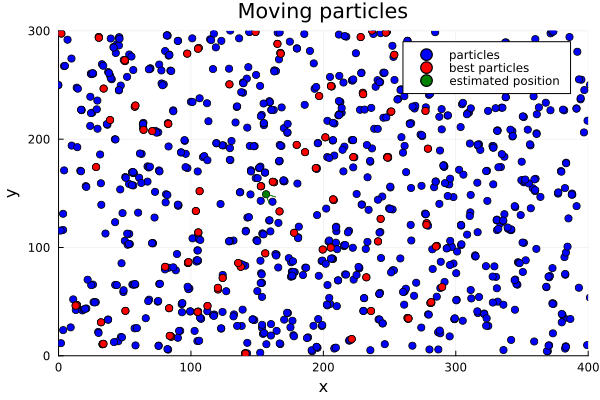

In [11]:
# - Update the weights and cumulative weights of the particles.

function update(particles, weights, cumulative)
  N = length(particles)
  updated_particles = []
  for i in 1:N
    w = weights[i]
    c = cumulative[i]
    push!(updated_particles, Particle(particles[i].x, particles[i].y, particles[i].vx, particles[i].vy, w, c))
  end
  return updated_particles
end

# - Visualize the current state of the particles and the estimated position and velocity.

function visualize(particles, x, y, vx, vy)
    N = length(particles)
    best_particles = sort(particles, by = p -> p.w, rev = true)[1:100]
    scatter([p.x for p in particles], [p.y for p in particles], color = :blue, label = "particles")
    scatter!([p.x for p in best_particles], [p.y for p in best_particles], color = :red, label = "best particles")
    scatter!([x], [y], color = :green, label = "estimated position")
    quiver!([x], [y], quiver = ([vx], [vy]), color = :green, label = "estimated velocity")
    sizey, sizex = size(images[:][1])
    xlims!(0, sizex)
    ylims!(0, sizey)
    title!("Moving particles")
    xlabel!("x")
    ylabel!("y")
    leg = false
end

# CREATE ANIMATION GIF

anim = Animation()
particles = init_particles()
for img in images
  # if no particles are given, initialize them
  particles = resample(particles)
  particles = predict(particles)
  weights, cumulative = measure_probability(img, particles)
  particles = update(particles, weights, cumulative)
  x, y, vx, vy = estimate(particles)
  visualize(particles, x, y, vx, vy)
  frame(anim)
end

gif(anim, "moving_particles.gif", fps = 15)

The algorithm is able to track the object in the face of various problems that arise from the image data, such as changes in motion direction, acceleration or deceleration, partial visibility due to noise, etc., by using a defined number of particles which are distributed over the search area and later accumulate around the rectangle by forming clusters. The algorithm is able to estimate the current position and velocity of the rectangle by using the arithmetic mean of the 100 best particles, and it moves around as the real rectangle moves. Additionally, there are two 1D-plots that visualize the velocities of the rectangle, one for vx and one for vy.